In [142]:
import pandas as pd
import heartpy as hp
import neurokit2 as nk

In [143]:
data = pd.read_pickle(f'/home/ilya/Documents/stress-level-by-PPG/filt_dataset.pkl')

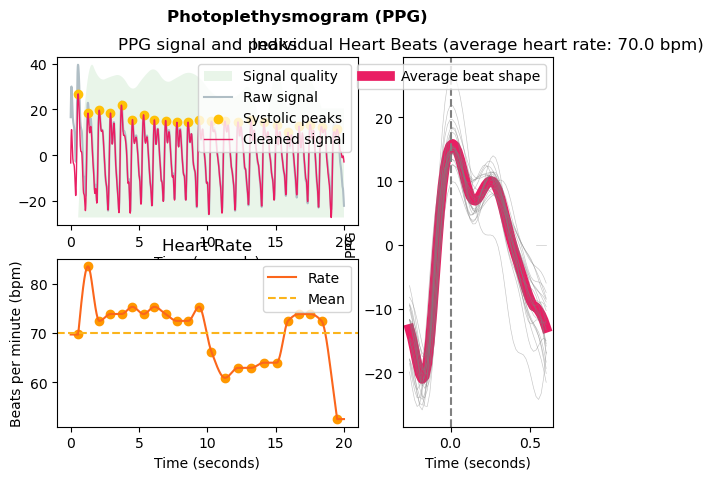

In [144]:
test_ppg = data['S15']['PPG_medit'][0:20 * 64]
signals, info = nk.ppg_process(test_ppg, sampling_rate=64)
nk.ppg_plot(signals, info)

In [145]:
print(f'Count sec for ppg signal')

for person_name, person_data in data.items():
    print(f"""{person_name}: md: {len(person_data['PPG_medit']) // 64}, st: {len(person_data['PPG_stress']) // 64}""")

Count sec for ppg signal
S4: md: 0, st: 14
S7: md: 270, st: 14
S13: md: 0, st: 0
S2: md: 271, st: 12
S14: md: 383, st: 0
S17: md: 34, st: 58
S3: md: 24, st: 13
S8: md: 0, st: 0
S9: md: 0, st: 93
S11: md: 0, st: 0
S16: md: 0, st: 13
S15: md: 295, st: 196
S6: md: 27, st: 58
S10: md: 334, st: 16
S5: md: 162, st: 0


In [146]:
fr_ppg = 64
wind_size = 10 * fr_ppg

dataset = []
feature = ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'stress_index']

In [147]:
def get_feature_hp(signal, label):
    _, m = hp.process(hp.scale_data(signal), sample_rate=fr_ppg, clean_rr=True)
    m['stress_index'] = label
    return m

def get_feature_nk(signal, label):
    peaks, _ = nk.ppg_peaks(signal, sampling_rate=fr_ppg, show=False)
    custom_scales = [4, 8, 16]

    hrv_indixes = nk.hrv(
        peaks, 
        sampling_rate=fr_ppg,
        nonlinear_kwargs={"scale": custom_scales}
    )
    hrv_indixes['stress_index'] = label

    filt_hrv_indixes = hrv_indixes[feature]
    return filt_hrv_indixes.iloc[0].to_dict()


In [148]:
get_feature_nk(test_ppg, 10)

/home/ilya/miniconda3/envs/PPG/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


{'HRV_MeanNN': 852.2727272727273,
 'HRV_SDNN': 67.4607319240727,
 'HRV_RMSSD': 51.822262349303124,
 'HRV_SDSD': 52.1688286388301,
 'HRV_CVNN': 0.07915392545757864,
 'HRV_CVSD': 0.060804787823182334,
 'HRV_MedianNN': 820.3125,
 'HRV_MadNN': 11.5828125,
 'HRV_pNN50': 18.181818181818183,
 'HRV_pNN20': 22.727272727272727,
 'HRV_MinNN': 734.375,
 'HRV_MaxNN': 968.75,
 'HRV_HTI': 2.75,
 'HRV_TINN': 78.125,
 'HRV_HF': 0.014244228456204768,
 'stress_index': 10.0}

In [149]:
def add_to_dataset(ppg, label):
    i = wind_size
    
    if len(ppg) >= (wind_size * 2):
        while(i + wind_size < len(ppg)):
            slice_ppg = ppg[i - wind_size : i + wind_size]
            dataset.append(get_feature_nk(slice_ppg, label))
            i += wind_size

    # elif len(ppg) > 10 * fr_ppg:
    #     dataset.append(get_feature_nk(ppg, label))

In [150]:
for person_name, person_data in data.items():
    ppg = person_data['PPG_medit']
    add_to_dataset(ppg, person_data['stress_lvl_for_medit'])

    ppg = person_data['PPG_stress']
    add_to_dataset(ppg, person_data['stress_lvl_for_stress'])


/home/ilya/miniconda3/envs/PPG/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/ilya/miniconda3/envs/PPG/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/ilya/miniconda3/envs/PPG/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the m

In [151]:
pd_dataset = pd.DataFrame(dataset)
pd_dataset.to_csv("ppg_feature.csv", index=False)